# Extract

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import pandas as pd
import os

# para matriz de correlación
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# creamos la sesión e indicamos que corra de forma local
spark = (SparkSession.builder
        .appName("Yelp ETL") # *

        # por defecto spark usa una cantidad de memoria 1GB aprox para el ejecutor
        # durante el desarrollo no fue suficente y el valor óptimo fue de 8g
        # además usar particiones mayores a 10 arruinaban el procesp
        .config("spark.executor.memory", "8g")  # aumentamos la memoria del ejecutor
        .config("spark.driver.memory", "8g")  # aumentamos la memoria del driver
        .config("spark.sql.shuffle.partitions", "10")  # ajustamos el número de particiones
        
        .master("local[*]") # *
        .getOrCreate()) # *

print(spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/25 11:20:11 WARN Utils: Your hostname, MacBook-Pro-de-johar.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.20 instead (on interface en0)
25/06/25 11:20:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/25 11:20:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


4.0.0


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 54076)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/Users/johar/Desktop/Big Data/25-1/yelp_project/yelp_project/lib/python3.11/site-packages/pyspark/accumulators.py", line 299, in handle
    poll(accum_updates)
  File "/Users/johar/

In [3]:
# rutas bronze
path_bronze_base = "../data/bronze/"

path_business = f"{path_bronze_base}yelp_academic_dataset_business.json"
path_checkin = f"{path_bronze_base}yelp_academic_dataset_checkin.json"
path_review = f"{path_bronze_base}yelp_academic_dataset_review.json"
path_tip = f"{path_bronze_base}yelp_academic_dataset_tip.json"
path_user = f"{path_bronze_base}yelp_academic_dataset_user.json"

# read
df_business = spark.read.json(path_business)
df_checkin = spark.read.json(path_checkin)
df_review = spark.read.json(path_review)
df_tip = spark.read.json(path_tip)
df_user = spark.read.json(path_user)

In [4]:
print(spark.version)

4.0.0


In [5]:
df_business.show()
df_business.printSchema()
df_business.describe().show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...| Santa Barbara|                NULL|      0|   34.4266787|  -119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|        Affton|{8:0-18:30, 0:0-0...|      1|   

25/06/25 11:20:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+--------------------+--------------------+-----------+------------------+-----------------+------------------+--------------------+------------------+-----------------+------------------+------+
|summary|          address|         business_id|          categories|       city|           is_open|         latitude|         longitude|                name|       postal_code|     review_count|             stars| state|
+-------+-----------------+--------------------+--------------------+-----------+------------------+-----------------+------------------+--------------------+------------------+-----------------+------------------+------+
|  count|           150346|              150346|              150243|     150346|            150346|           150346|            150346|              150346|            150346|           150346|            150346|150346|
|   mean|7369.333333333333|                NULL|                NULL|       NULL|0.7961502135075094|36.671150064

In [6]:
df_checkin.show()
df_checkin.printSchema()
df_checkin.describe().show()

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|2020-03-13 21:10:...|
|--0iUa4sNDFiZFrAd...|2010-09-13 21:43:...|
|--30_8IhuyMHbSOcN...|2013-06-14 23:29:...|
|--7PUidqRWpRSpXeb...|2011-02-15 17:12:...|
|--7jw19RH9JKXgFoh...|2014-04-21 20:42:...|
|--8IbOsAAxjKRoYsB...|2015-06-06 01:03:...|
|--9osgUCSDUWUkoTL...|2015-06-13 02:00:...|
|--ARBQr1WMsTWiwOK...|2014-12-12 00:44:...|
|--FWWsIwxRwuw9vIM...|2010-09-11 16:28:...|
|--FcbSxK1AoEtEAxO...|2017-08-18 19:43:...|
|--LC8cIrALInl2vyo...|2017-01-12 19:10:...|
|--MbOh2O1pATkXa7x...|2013-04-21 01:52:...|
|--N9yp3ZWqQIm7DqK...|2012-10-06 20:46:...|
|--O3ip9NpXTKD4oBS...|2010-04-17 21:07:...|
|--OS_I7dnABrXvRCC...| 2018-05-11 18:23:36|
|--S43ruInmIsGrnnk...|2010-08-29 01:17:...|
|--SJXpAa0E-GCp2sm...|2014-04-06 22:23:...|
|--Sd93OFWITqDHifM...|2013-01-09 17:42:...|
|--ZVrH2X2QXBFdCil...|2010-08-12 18:21:...|
|--ZWv8kGlM2YL58uK...|2010-10-13

In [7]:
df_review.show()
df_review.printSchema()
df_review.describe().show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

+-------+--------------------+------------------+-------------------+-------------------+--------------------+------------------+----------------------+------------------+--------------------+
|summary|         business_id|              cool|               date|              funny|           review_id|             stars|                  text|            useful|             user_id|
+-------+--------------------+------------------+-------------------+-------------------+--------------------+------------------+----------------------+------------------+--------------------+
|  count|             6990280|           6990280|            6990280|            6990280|             6990280|           6990280|               6990280|           6990280|             6990280|
|   mean|                NULL|0.4986175088837643|               NULL|0.32655959417934616|                NULL|  3.74858374771826|                  NULL|1.1846089140921394|                NULL|
| stddev|                NULL|2.172

In [8]:
df_tip.show(5)
df_tip.printSchema()
df_tip.describe().show()

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|3uLgwr0qeCNMjKenH...|               0|2012-05-18 02:17:21|Avengers time wit...|AGNUgVwnZUey3gcPC...|
|QoezRbYQncpRqyrLH...|               0|2013-02-05 18:35:10|They have lots of...|NBN4MgHP9D3cw--Sn...|
|MYoRNLb5chwjQe3c_...|               0|2013-08-18 00:56:08|It's open even wh...|-copOvldyKh1qr-vz...|
|hV-bABTK-glh5wj31...|               0|2017-06-27 23:05:38|Very decent fried...|FjMQVZjSqY8syIO-5...|
|_uN0OudeJ3Zl_tf6n...|               0|2012-10-06 19:43:09|Appetizers.. plat...|ld0AperBXk1h6Ubqm...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 5 rows
root
 |-- business_id: string (nullable = true)
 |-- compl

+-------+--------------------+--------------------+-------------------+--------------------+--------------------+
|summary|         business_id|    compliment_count|               date|                text|             user_id|
+-------+--------------------+--------------------+-------------------+--------------------+--------------------+
|  count|              908915|              908915|             908915|              908915|              908915|
|   mean|                NULL|0.012524823553357574|               NULL|1.792114762548089...|                NULL|
| stddev|                NULL| 0.12076339327984326|               NULL|1.411112521356809...|                NULL|
|    min|---kPU91CF4Lq2-Wl...|                   0|2009-04-16 13:11:49|                   !|---r61b7EpVPkb4UV...|
|    max|zzyx5x0Z7xXWWvWnZ...|                   6|2022-01-19 20:38:55|to the apple gor...|zzxZW6U5lCCQQeVfL...|
+-------+--------------------+--------------------+-------------------+-----------------

In [9]:
df_user.show()
df_user.printSchema()
df_user.describe().show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|     name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|         

+-------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+-----------------+------------------+-------------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+------------+------------------+-----------------+--------------------+-------------------+
|summary|     average_stars|   compliment_cool|    compliment_cute|  compliment_funny|    compliment_hot|    compliment_list|    compliment_more|   compliment_note|compliment_photos|  compliment_plain| compliment_profile|compliment_writer|              cool|            elite|              fans|             friends|             funny|        name|      review_count|           useful|             user_id|      yelping_since|
+-------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-

# Transform

## Review

- review_id
- user_id
- business_id
- stars
- text
- date

stars: Calificación individual de cada reseña (1-5 estrellas, dada por un usuario para un negocio).

será renombrada al final a reviews_stars para evitar conflicto

In [10]:
df_filter_review = df_review.select("review_id", "user_id", "business_id", "stars", "text", "date")

In [11]:
# cantidad de registos
df_filter_review.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+----------------------+-------------------+
|summary|           review_id|             user_id|         business_id|             stars|                  text|               date|
+-------+--------------------+--------------------+--------------------+------------------+----------------------+-------------------+
|  count|             6990280|             6990280|             6990280|           6990280|               6990280|            6990280|
|   mean|                NULL|                NULL|                NULL|  3.74858374771826|                  NULL|               NULL|
| stddev|                NULL|                NULL|                NULL|1.4787045052556855|                  NULL|               NULL|
|    min|---4VcQZzy_vIIifU...|---1lKK3aKOuomHnw...|---kPU91CF4Lq2-Wl...|               1.0|  !\nMilk Bar is po...|2005-02-16 03:23:22|
|    max|zzzz1ADBqBEVyfX4l...|zzzUFM4HFe0SFG0bP...|zzyx

In [12]:
# nulos
df_filter_review.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c + '_nulos') 
    for c in df_filter_review.columns
]).show()


+---------------+-------------+-----------------+-----------+----------+----------+
|review_id_nulos|user_id_nulos|business_id_nulos|stars_nulos|text_nulos|date_nulos|
+---------------+-------------+-----------------+-----------+----------+----------+
|              0|            0|                0|          0|         0|         0|
+---------------+-------------+-----------------+-----------+----------+----------+



In [13]:
# únicos de stars
df_filter_review.groupBy("stars").count().orderBy("stars").show()

+-----+-------+
|stars|  count|
+-----+-------+
|  1.0|1069561|
|  2.0| 544240|
|  3.0| 691934|
|  4.0|1452918|
|  5.0|3231627|
+-----+-------+



In [14]:
df_filter_review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- date: string (nullable = true)



In [15]:
# -> timestamp
df_filter_review = df_filter_review.withColumn("date", F.to_timestamp("date", "yyyy-MM-dd HH:mm:ss"))
df_filter_review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- date: timestamp (nullable = true)



In [16]:
# vemos la serie temporal por un negocio
df_negocio = df_filter_review.filter(df_filter_review.business_id == '7ATYjTIgM3jUlt4UM3IypQ')
df_negocio_serie_temporal = df_negocio.groupBy(F.year("date").alias("año"), F.month("date").alias("mes")) \
    .count() \
    .orderBy("año", "mes")
df_negocio_serie_temporal.show()

+----+---+-----+
| año|mes|count|
+----+---+-----+
|2010| 11|    2|
|2010| 12|    4|
|2011|  2|    1|
|2011|  3|    2|
|2011|  4|    2|
|2011|  5|    3|
|2011|  6|    3|
|2011|  7|    9|
|2011|  8|    2|
|2011| 12|    2|
|2012|  1|    3|
|2012|  2|    3|
|2012|  3|    2|
|2012|  4|    4|
|2012|  5|    1|
|2012|  8|    4|
|2012|  9|    3|
|2012| 10|    2|
|2012| 11|    4|
|2012| 12|    4|
+----+---+-----+
only showing top 20 rows


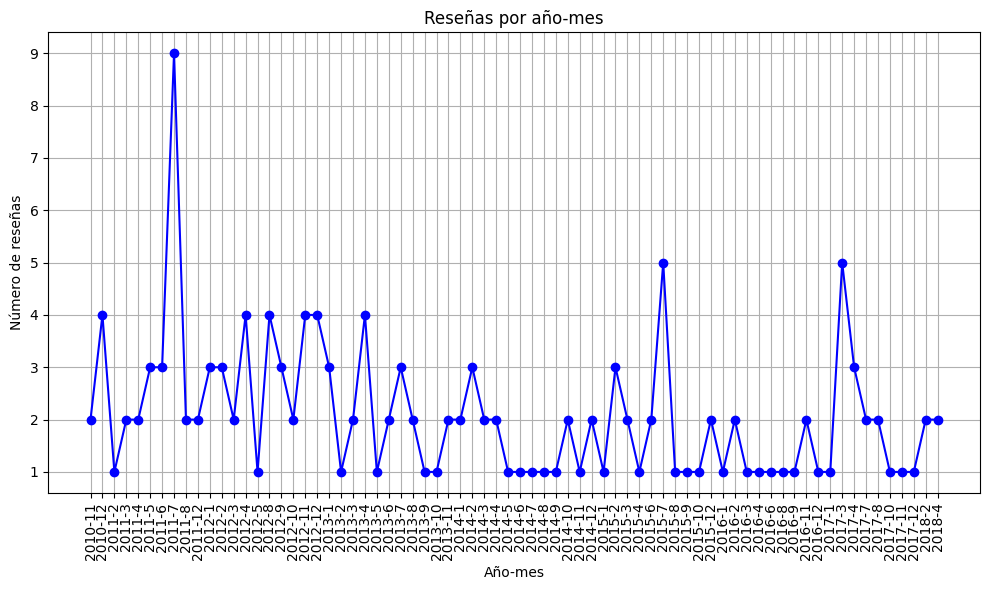

In [17]:
# pasamos a pandas para graficar 
df_negocio_serie_temporal_pd = df_negocio_serie_temporal.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df_negocio_serie_temporal_pd['año'].astype(str) + '-' + df_negocio_serie_temporal_pd['mes'].astype(str),
         df_negocio_serie_temporal_pd['count'], marker='o', linestyle='-', color='b')
plt.title('Reseñas por año-mes')
plt.xlabel('Año-mes')
plt.ylabel('Número de reseñas')
plt.xticks(rotation=90) # para ver bien los labels
plt.grid(True)
plt.tight_layout()
plt.show()

Verificamos y tenemos los registros completos por cada variable, stars se maneja en un rango de 1-5, formateamos date y usando id de negocios de prueba vemos su series temporal de reseñas por mes-año

## User

- user_id
- review_count
- average_stars
- yelping_since

In [18]:
df_filter_user = df_user.select("user_id", "review_count", "average_stars", "yelping_since")

In [19]:
df_filter_user.describe().show()

+-------+--------------------+------------------+------------------+-------------------+
|summary|             user_id|      review_count|     average_stars|      yelping_since|
+-------+--------------------+------------------+------------------+-------------------+
|  count|             1987897|           1987897|           1987897|            1987897|
|   mean|                NULL|23.394409267683386|  3.63049415035087|               NULL|
| stddev|                NULL| 82.56699161797889|1.1833369995975145|               NULL|
|    min|---1lKK3aKOuomHnw...|                 0|               1.0|2004-10-12 08:46:11|
|    max|zzzUFM4HFe0SFG0bP...|             17473|               5.0|2022-01-19 17:15:47|
+-------+--------------------+------------------+------------------+-------------------+



In [20]:
df_filter_user.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c + '_nulos') 
    for c in df_filter_user.columns
]).show()

+-------------+------------------+-------------------+-------------------+
|user_id_nulos|review_count_nulos|average_stars_nulos|yelping_since_nulos|
+-------------+------------------+-------------------+-------------------+
|            0|                 0|                  0|                  0|
+-------------+------------------+-------------------+-------------------+



In [21]:
df_filter_user.groupBy("average_stars").count().orderBy("average_stars").show()

+-------------+------+
|average_stars| count|
+-------------+------+
|          1.0|165899|
|         1.01|     1|
|         1.02|     3|
|         1.03|     5|
|         1.04|    15|
|         1.05|    17|
|         1.06|    25|
|         1.07|    31|
|         1.08|    55|
|         1.09|    48|
|          1.1|    71|
|         1.11|   108|
|         1.12|    13|
|         1.13|   152|
|         1.14|   271|
|         1.15|    28|
|         1.16|    15|
|         1.17|   464|
|         1.18|    54|
|         1.19|    31|
+-------------+------+
only showing top 20 rows


In [22]:
df_filter_user.printSchema() 

root
 |-- user_id: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- yelping_since: string (nullable = true)



In [23]:
# cambiamos el tipo de dato de yelping_since
df_filter_user = df_filter_user.withColumn("yelping_since", F.to_timestamp("yelping_since", "yyyy-MM-dd HH:mm:ss"))
df_filter_user.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- yelping_since: timestamp (nullable = true)



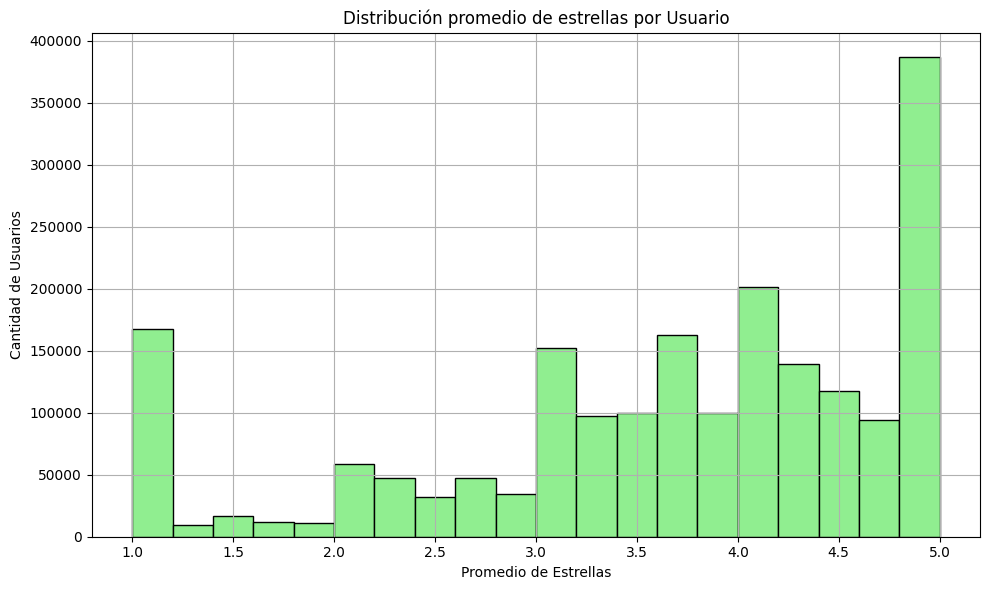

In [24]:
# para graficar
df_reviews_pd = df_filter_user.toPandas()

# promedio de estrellas por usuario
plt.figure(figsize=(10, 6))
plt.hist(df_reviews_pd['average_stars'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribución promedio de estrellas por Usuario')
plt.xlabel('Promedio de Estrellas')
plt.ylabel('Cantidad de Usuarios')
plt.grid(True)
plt.tight_layout()
plt.show()

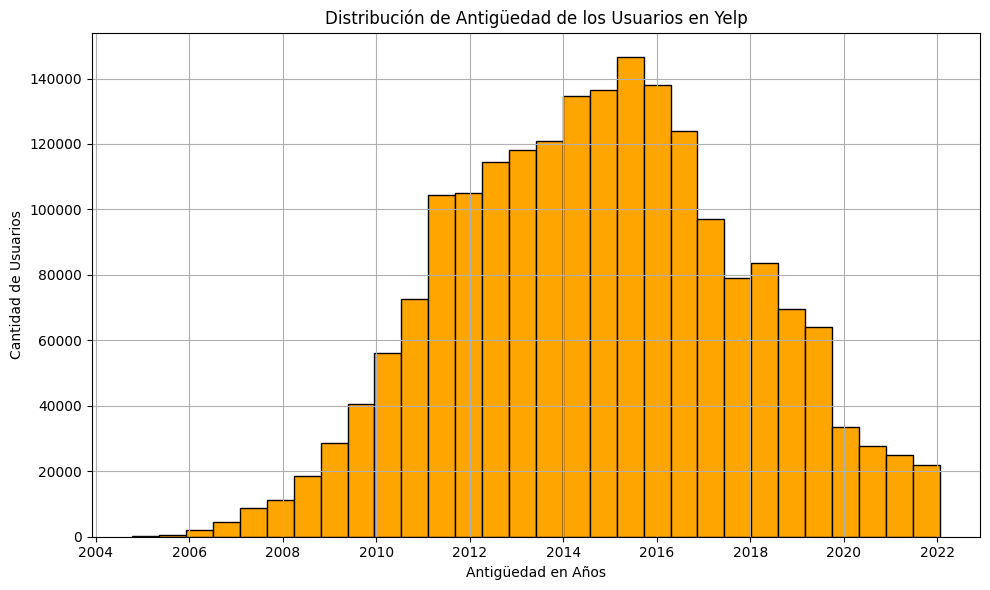

In [25]:
# antigüedad de los usuarios
plt.figure(figsize=(10, 6))
plt.hist(df_reviews_pd['yelping_since'], bins=30, color='orange', edgecolor='black')
plt.title('Distribución de Antigüedad de los Usuarios en Yelp')
plt.xlabel('Antigüedad en Años')
plt.ylabel('Cantidad de Usuarios')
plt.grid(True)
plt.tight_layout()
plt.show()

## Business

- business_id
- name
- city
- state
- latitude
- longitude
- categories
- stars
- review_count

stars: Promedio de las calificaciones de todas las reseñas de un negocio específico (puntuación promedio de 1 a 5 estrellas de todos los usuarios que han dejado reseñas para ese negocio).

será renombrada al final a reviews_stars para evitar conflicto

In [26]:
df_filter_business = df_business.select("business_id", "name", "city", "state", "latitude", "longitude", "categories", "stars", "review_count")

In [27]:
df_filter_business.describe().show()

+-------+--------------------+--------------------+-----------+------+-----------------+------------------+--------------------+------------------+-----------------+
|summary|         business_id|                name|       city| state|         latitude|         longitude|          categories|             stars|     review_count|
+-------+--------------------+--------------------+-----------+------+-----------------+------------------+--------------------+------------------+-----------------+
|  count|              150346|              150346|     150346|150346|           150346|            150346|              150243|            150346|           150346|
|   mean|                NULL|              1252.4|       NULL|  NULL|36.67115006414571|-89.35733948971429|                NULL|3.5967235576603303|44.86656113232144|
| stddev|                NULL|   811.1275005954503|       NULL|  NULL|5.872758917014048| 14.91850167993062|                NULL|0.9744207509201364|121.1201357011708|
|   

In [28]:
df_filter_business.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c + '_nulos') 
    for c in df_filter_business.columns
]).show()

+-----------------+----------+----------+-----------+--------------+---------------+----------------+-----------+------------------+
|business_id_nulos|name_nulos|city_nulos|state_nulos|latitude_nulos|longitude_nulos|categories_nulos|stars_nulos|review_count_nulos|
+-----------------+----------+----------+-----------+--------------+---------------+----------------+-----------+------------------+
|                0|         0|         0|          0|             0|              0|             103|          0|                 0|
+-----------------+----------+----------+-----------+--------------+---------------+----------------+-----------+------------------+



In [29]:
# revisamos nulos
df_filter_business.filter(F.col("categories").isNull()).show()


+--------------------+--------------------+----------------+-----+----------+------------+----------+-----+------------+
|         business_id|                name|            city|state|  latitude|   longitude|categories|stars|review_count|
+--------------------+--------------------+----------------+-----+----------+------------+----------+-----+------------+
|SMYXOLPyM95JvZ-oq...|A A Berlin Glass ...|          Berlin|   NJ|39.8004163| -74.9371806|      NULL|  3.0|           5|
|9ryVeDaaR-le3kiSa...|Pauline African H...|       Saint Ann|   MO|38.7260321| -90.3793227|      NULL|  1.0|           5|
|xT3J-SP5g49g2FjQf...|      Luxury Perfume|            Reno|   NV|39.4756225|-119.7833497|      NULL|  2.0|           5|
|_obl2-rphXvtzP3y_...|Certegy Payment S...|Saint Petersburg|   FL|27.8774633| -82.6535459|      NULL|  1.0|           7|
|mKxCNYEoKt6d_1rXm...|          Green Envy|   Saint Charles|   MO| 38.826533| -90.4722239|      NULL|  1.5|           5|
|9QoKKDZB_YuDeS5Tx...|   Our 365

In [30]:
# no sabemos la razón exacta de los nulos y debido a que representa el 0.0685% del total, lo eliminamos

df_filter_business = df_filter_business.filter(F.col("categories").isNotNull())

# verificamos
df_filter_business.filter(F.col("categories").isNull()).show()

+-----------+----+----+-----+--------+---------+----------+-----+------------+
|business_id|name|city|state|latitude|longitude|categories|stars|review_count|
+-----------+----+----+-----+--------+---------+----------+-----+------------+
+-----------+----+----+-----+--------+---------+----------+-----+------------+



In [31]:
df_filter_business.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c + '_nulos') 
    for c in df_filter_business.columns
]).show()

+-----------------+----------+----------+-----------+--------------+---------------+----------------+-----------+------------------+
|business_id_nulos|name_nulos|city_nulos|state_nulos|latitude_nulos|longitude_nulos|categories_nulos|stars_nulos|review_count_nulos|
+-----------------+----------+----------+-----------+--------------+---------------+----------------+-----------+------------------+
|                0|         0|         0|          0|             0|              0|               0|          0|                 0|
+-----------------+----------+----------+-----------+--------------+---------------+----------------+-----------+------------------+



In [32]:
# distribución de stars
df_filter_business.groupBy("stars").count().orderBy("stars").show()

+-----+-----+
|stars|count|
+-----+-----+
|  1.0| 1948|
|  1.5| 4918|
|  2.0| 9515|
|  2.5|14307|
|  3.0|18448|
|  3.5|26512|
|  4.0|31120|
|  4.5|27174|
|  5.0|16301|
+-----+-----+



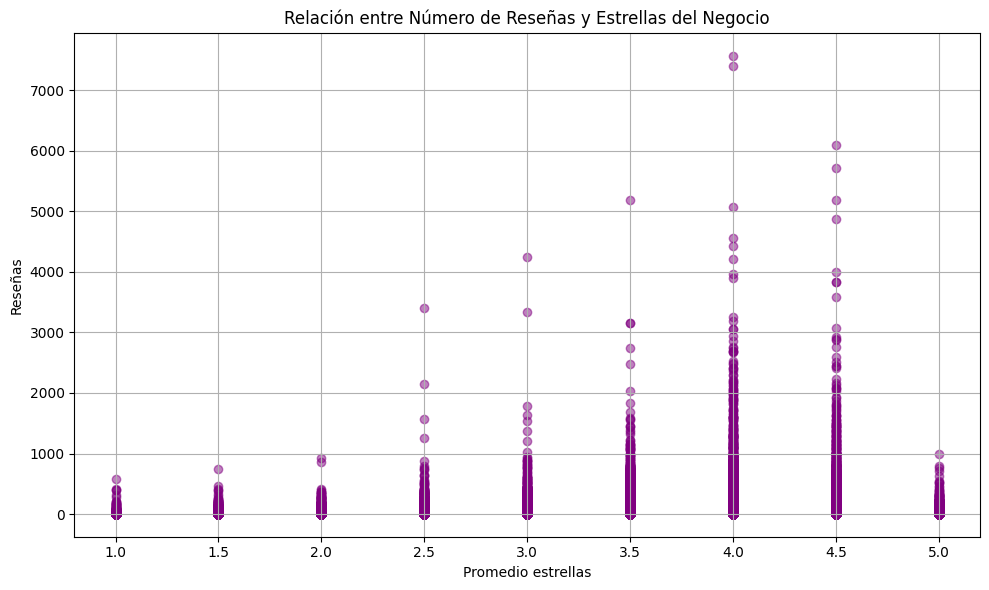

In [33]:
df_business_pd = df_filter_business.toPandas()
# relación entre review_count y stars para ver si hay alguna correlación
plt.figure(figsize=(10, 6))
plt.scatter(df_business_pd['stars'], df_business_pd['review_count'], color='purple', alpha=0.5)
plt.title('Relación entre Número de Reseñas y Estrellas del Negocio')
plt.xlabel('Promedio estrellas')
plt.ylabel('Reseñas')
plt.grid(True)
plt.tight_layout()
plt.show()

> Verificamos que en los 3 principales datasets, pasaron por un proceso de EDA y actualmente están listas para usar e integrarlas en un dataset

# Join

Usaremos inner join porque queremos crear un dataset donde cada reseña, el usuario que la escribió y el negocio al que pertenece, estén todos conectados y existan.


In [34]:
# antes, renombraremos stars (review, business) para evitar conflicto
df_filter_review = df_filter_review.withColumnRenamed("stars", "review_stars")
df_filter_business = df_filter_business.withColumnRenamed("stars", "business_stars")

# lo mismo hacemos con review_count (user, business)
df_filter_business = df_filter_business.withColumnRenamed("review_count", "business_review_count")
df_filter_user = df_filter_user.withColumnRenamed("review_count", "user_review_count")


In [35]:
# reseñas con negocios
df_reseñas_negocios = df_filter_review.join(df_filter_business, on="business_id", how="inner")

# con usuarios
df_completo = df_reseñas_negocios.join(df_filter_user, on="user_id", how="inner")

# df final
df_completo.show(5, truncate=False)



+----------------------+----------------------+----------------------+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+---------------------------------+-----------+-----+-------------+--------------+---------------------------------------------------------------------------------+--------------+---------------------+-----------------+-------------+-------------------+
|user_id               |business_id           |review_id             |review_stars|t

In [46]:
# convertimos el df a RDD para contar el tamaño
df_size_in_bytes = df_completo.rdd.map(lambda x: len(str(x))).sum()
df_size_gb = df_size_in_bytes / (1024 ** 3)

print(f"Tamaño DF en memoria (Spark): {df_size_gb:.2f} GB")

Tamaño DF en memoria (Spark): 7.06 GB


25/06/25 14:35:34 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 186561 ms exceeds timeout 120000 ms
25/06/25 14:35:34 WARN SparkContext: Killing executors is not supported by current scheduler.
25/06/25 14:35:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [36]:
df_completo.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- categories: string (nullable = true)
 |-- business_stars: double (nullable = true)
 |-- business_review_count: long (nullable = true)
 |-- user_review_count: long (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- yelping_since: timestamp (nullable = true)



In [37]:
df_completo.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c + '_nulos') 
    for c in df_completo.columns
]).show()

+-------------+-----------------+---------------+------------------+----------+----------+----------+----------+-----------+--------------+---------------+----------------+--------------------+---------------------------+-----------------------+-------------------+-------------------+
|user_id_nulos|business_id_nulos|review_id_nulos|review_stars_nulos|text_nulos|date_nulos|name_nulos|city_nulos|state_nulos|latitude_nulos|longitude_nulos|categories_nulos|business_stars_nulos|business_review_count_nulos|user_review_count_nulos|average_stars_nulos|yelping_since_nulos|
+-------------+-----------------+---------------+------------------+----------+----------+----------+----------+-----------+--------------+---------------+----------------+--------------------+---------------------------+-----------------------+-------------------+-------------------+
|            0|                0|              0|                 0|         0|         0|         0|         0|          0|             0|   

In [38]:
df_completo.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+-----------+-------+------------------+------------------+--------------------+------------------+---------------------+------------------+------------------+
|summary|             user_id|         business_id|           review_id|      review_stars|                  text|                name|       city|  state|          latitude|         longitude|          categories|    business_stars|business_review_count| user_review_count|     average_stars|
+-------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+-----------+-------+------------------+------------------+--------------------+------------------+---------------------+------------------+------------------+
|  count|             6989558|             6989558|             6989558|           6989558|               6989558|    

Usaremos polars para graficar la matriz de correlación

Esto es a modo experimento donde el siguiente código producirá error porque estamos realizando una operación que requiere más memoria de la que tenemos disponible. 
En nuesto caso ocurrió por intentar mover grandes cantidades de datos entre spark y pandas ´df_completo.toPandas()´.
Aquí pandas cargo todo a memoria y por ser un caso de big data, causo problemas

In [39]:
"""
import polars as pl
import seaborn as sns

df_polars = pl.from_pandas(df_completo.toPandas())

# solo numéricas
numerical_columns = [col for col, dtype in zip(df_polars.columns, df_polars.dtypes) if dtype in ('int64', 'float64')]

df_numeric = df_polars.select(numerical_columns)

corr_matrix = df_numeric.corr()
corr_matrix_df = corr_matrix.to_pandas()

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación con Polars")
plt.show()
"""

'\nimport polars as pl\nimport seaborn as sns\n\ndf_polars = pl.from_pandas(df_completo.toPandas())\n\n# solo numéricas\nnumerical_columns = [col for col, dtype in zip(df_polars.columns, df_polars.dtypes) if dtype in (\'int64\', \'float64\')]\n\ndf_numeric = df_polars.select(numerical_columns)\n\ncorr_matrix = df_numeric.corr()\ncorr_matrix_df = corr_matrix.to_pandas()\n\n# heatmap\nplt.figure(figsize=(12, 8))\nsns.heatmap(corr_matrix_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)\nplt.title("Matriz de Correlación con Polars")\nplt.show()\n'

Lo interesante aquí es que este error, de alguna forma afecto la sesión actual de spark.
Algunas de las operaciones que ejecutó pandas o polars que están relacionadas con el manejo de memoria, pudo haber afectado la estabilidad de la sesión


25/06/25 11:24:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


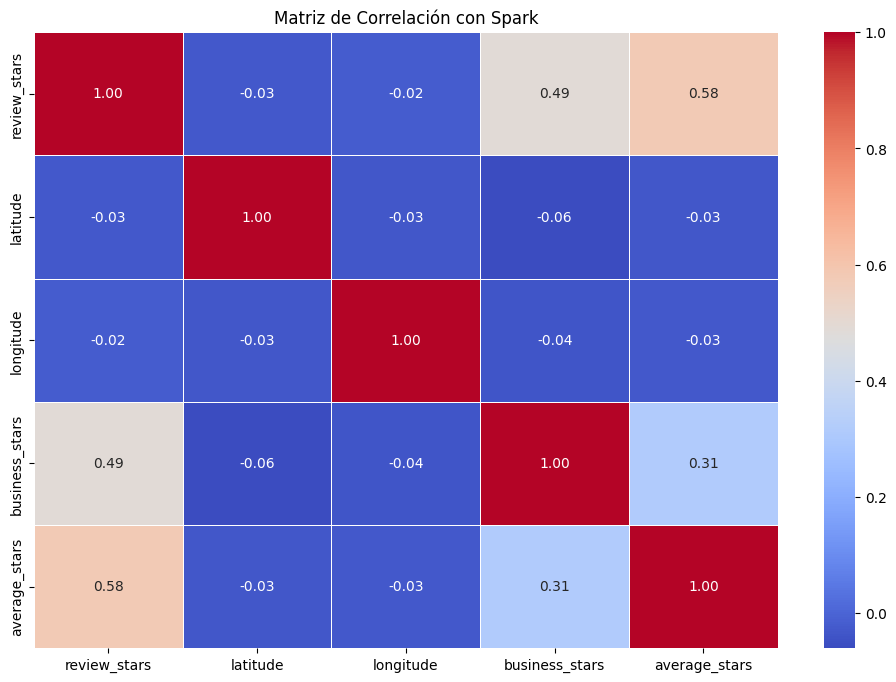

In [40]:
# filtro solo numéricas
numerical_columns = [c for c, dtype in df_completo.dtypes if dtype in ('int', 'double')]

# spark requiere tenerlas en un vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
df_vector = assembler.transform(df_completo)

correlation_matrix = Correlation.corr(df_vector, "features", "pearson").head()

# pasamos a array para poder visuaizar
corr_matrix = correlation_matrix[0].toArray()
corr_matrix_df = pd.DataFrame(corr_matrix, columns=numerical_columns, index=numerical_columns)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación con Spark")
plt.show()

- Vemos una correlación moderada entre las reseñas de los usuarios y las estrellas promedio del negocio, lo que podría ser indicio que los negocios con buenas calificaciones tienden a recibir buenas reseñas

- Además la relación entre las estrellas de reseña y el promedio de estrellas del usuario también muestra una correlación positiva, lo que indicaría que los usuarios dan calificaciones similares a sus reseñas previas.

# Save

Guardamos en formato parquet para considerar aprovechar mantener el esquema actual, además está optimizado para spark y compatible HDFS

In [41]:
path_parquet = "../data/silver"

In [42]:
# ajustamos a 10 particiones porque de lo contrario excedemos el 95% de memoria disponible
df_completo = df_completo.repartition(10)
# divide el df en 10 particiones de manera equitativa, es decir, lo hicimos sin particionamiento explícito

df_completo.write.parquet(path_parquet, mode="overwrite")

In [43]:
# leer
df_completo_parquet = spark.read.parquet(path_parquet)

df_completo_parquet.show(5)

+--------------------+--------------------+--------------------+------------+--------------------+-------------------+--------------------+--------------+-----+------------+-----------+--------------------+--------------+---------------------+-----------------+-------------+-------------------+
|             user_id|         business_id|           review_id|review_stars|                text|               date|                name|          city|state|    latitude|  longitude|          categories|business_stars|business_review_count|user_review_count|average_stars|      yelping_since|
+--------------------+--------------------+--------------------+------------+--------------------+-------------------+--------------------+--------------+-----+------------+-----------+--------------------+--------------+---------------------+-----------------+-------------+-------------------+
|V_j-mYsa8Xrn_KEw-...|8pqdJjefYq-a9IBSJ...|qwFjyODKMeBR84Lyh...|         4.0|Wish it wasn't so...|2016-03-01 04:

Veremos que en la capa silver (carpeta silver) se crearon las particiones (.part-00...) en formato parquet


Para una próxima lectura, spark de forma automática maneja las particiones internamente y no es necesario recorrerlas manualmente

In [45]:
path_parquet = "../data/silver"

# función recursiva para obtener el tamaño de los archivos en subdirectorios
def get_total_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for file in filenames:
            total_size += os.path.getsize(os.path.join(dirpath, file))
    return total_size

total_size = get_total_size(path_parquet)
total_size_gb = total_size / (1024 ** 3)

print(f"Tamaño archivo Parquet: {total_size_gb:.2f} GB")

Tamaño archivo Parquet: 3.27 GB


In [ ]:
# buena práctica 🤓
spark.stop()